## DeepXDE求解常微分方程
这个notebook展示了使用DeepXDE求解常微分方程。

## 问题设置

我们将求解一个简单的 ODE 系统：

$$\large \frac{dy_1}{dt} = y ,\,\,\,\, \frac{dy_2}{dt} = -y_1,\,\,\,\, where \,\,\,\,t∈[0,10],$$



与初始条件 $\large y_1(0)=0,y_2(0)=1.$

参考解决方案是 $$ \large  y_1 = \sin(x) ,\,\,\,\, y_2 = \cos(x).$$

源码：

https://github.com/lululxvi/deepxde/blob/master/examples/pinn_forward/ode_system.py

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/ode.system.html

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



data.PDE

指定几何区域、ODE 和初始条件

In [2]:
def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]

def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

In [3]:
geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, np.sin, boundary, component=0)
ic2 = dde.icbc.IC(geom, np.cos, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

G:\Anaconda3\envs\py3.8\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+37=37. 
  warnings.warn("The balance properties of Sobol' points require "


net

In [4]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model

In [5]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.069716 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 3.130456 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [9.25e-01, 5.92e-02, 0.00e+00, 1.00e+00]    [9.52e-01, 5.34e-02, 0.00e+00, 1.00e+00]    [1.48e+00]    
1000      [9.30e-03, 8.42e-03, 1.55e-08, 4.16e-04]    [1.04e-02, 7.85e-03, 1.55e-08, 4.16e-04]    [8.08e-01]    
2000      [5.30e-03, 4.52e-03, 1.33e-06, 1.22e-04]    [5.37e-03, 4.36e-03, 1.33e-06, 1.22e-04]    [5.93e-01]    
3000      [2.67e-03, 3.11e-03, 2.86e-06, 4.88e-05]    [2.81e-03, 2.98e-03, 2.86e-06, 4.88e-05]    [4.17e-01]    
4000      [9.92e-04, 1.65e-03, 3.58e-06, 1.68e-05]    [1.05e-03, 1.45e-03, 3.58e-06, 1.68e-05]    [2.58e-01]    
5000      [1.15e-04, 1.72e-04, 4.65e-08, 1.17e-06]    [1.21e-04, 1.46e-04, 4.65e-08, 1.17e-06]    [6.27e-02]    
6000      [2.31e-04, 6.60e-05, 2.63e-05, 7.82e-06]    [2.39e-04, 6.74e-05, 2.63e-05, 7.82e-06]    [1.71e-02]    
7000      [3.11e-05, 1.5

plot

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

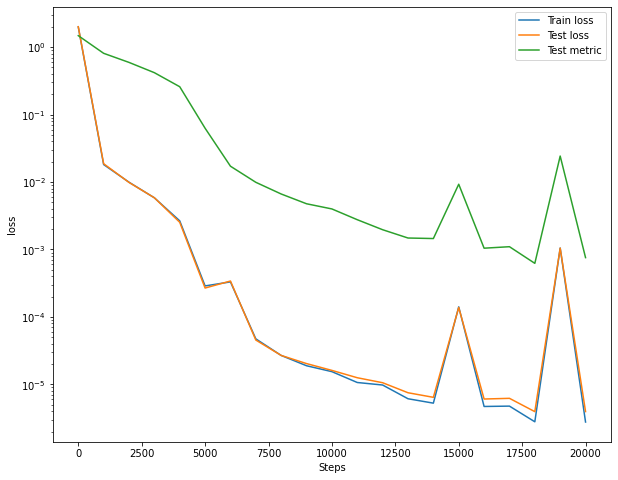

In [7]:
plot_loss_history(losshistory)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=(10, 6))
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()


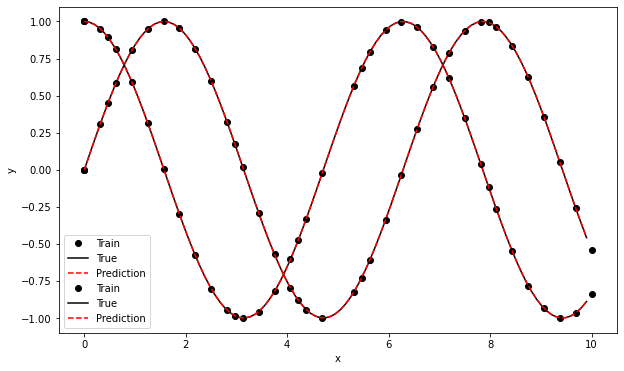

In [9]:
plot_best_state(train_state)

## 学到更多

求解一个 Lotka-Volterra 方程：https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/lotka.volterra.html

https://deepxde.readthedocs.io/en/latest/demos/pinn_forward.html#odes